### Exploratory Data Analysis
#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
import plotly.express as px
from IPython.display import display



#### Fetch Data

In [2]:
df = pd.read_csv("../consumption_temp.csv")
# Convert dftypes
df["time"] = pd.to_datetime(df["time"])
df["consumption"] = pd.to_numeric(df["consumption"])
df["temperature"] = pd.to_numeric(df["temperature"])
df_cities = {location: df[df["location"] == location] for location in df["location"].unique()}

#### Descriptive analysis

In [3]:
df.head(3)

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3


In [4]:
df.groupby('location').describe().round(decimals=2)

consumption                                              \
                  count  mean   std   min   25%   50%    75%    max   
location                                                              
bergen           8641.0  1.88  1.16  0.44  0.83  1.38   3.00   4.65   
helsingfors      6289.0  6.08  0.92  0.00  6.19  6.35   6.47   7.86   
oslo             8641.0  6.88  4.67  1.52  2.61  4.87  11.46  18.05   
stavanger        8641.0  3.30  2.11  0.83  1.38  2.39   5.40   8.76   
tromsø           8641.0  1.34  0.56  0.37  0.83  1.20   1.87   2.55   
trondheim        8641.0  2.28  1.14  0.62  1.26  1.84   3.38   5.10   

            temperature                                          
                  count  mean   std   min  25%  50%   75%   max  
location                                                         
bergen           8641.0  7.75  6.56 -15.6  3.1  8.1  12.2  29.3  
helsingfors      6289.0  5.66  7.59 -10.1 -0.3  3.1  11.6  24.0  
oslo             8641.0  7.39  8.77 -15.4  0.9  7.9  14.2  29.8  
stavanger        8641.0  8.55  5.84  -9.2  4.3  8.9  12.7  27.0  
tromsø           8641.0  3.51  7.97 -14.6 -2.6  2.8   9.6  29.8  
trondheim        8641.0  6.21  7.62 -17.3  1.1  6.5  11.6  30.5

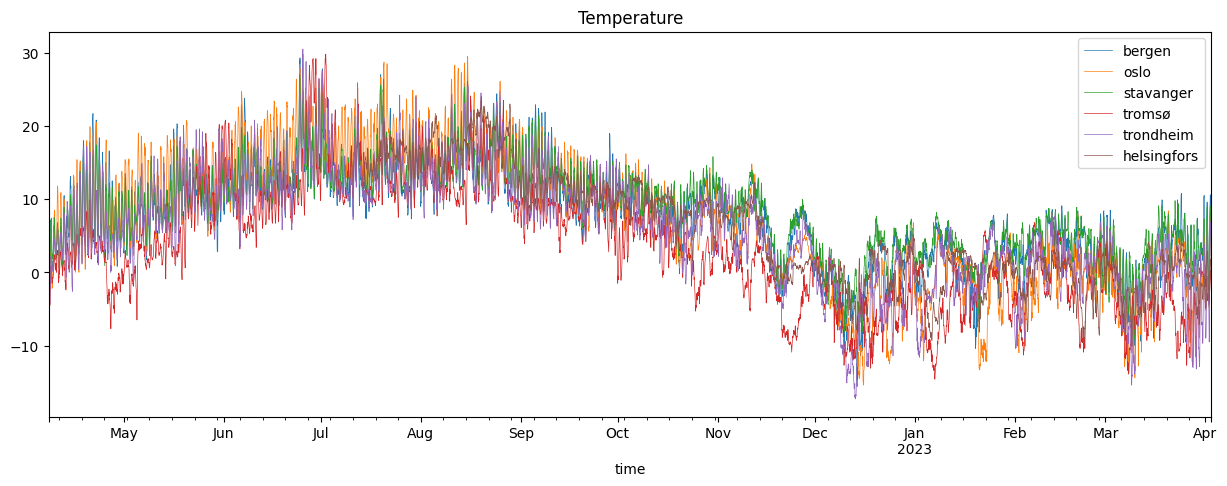

In [36]:
for location in df.location.unique():
    #df[df.location == location].set_index('time').temperature.plot(title=location + ' temperature')
    # plt.show()
    df[df.location == location].set_index('time').temperature.rolling('1H').mean().plot(label=location, title='Temperature', figsize=(15,5), linewidth=0.5)
plt.legend()
plt.show()

In [33]:
fig = px.line(df, x="time", y="temperature", color="location", labels={"consumption": "Consumption", "time": "Time"},
              title="Consumption", width=1000, height=500)

fig.show()

#### Check for missing data

In [12]:
df[df.isna().any(axis=1)]

,time,location,consumption,temperature


In [22]:
df[df.location == 'helsingfors']

,time,location,consumption,temperature
11761,2022-07-14 21:00:00,helsingfors,0.000,15.8
11767,2022-07-14 22:00:00,helsingfors,0.000,15.4
11773,2022-07-14 23:00:00,helsingfors,0.000,15.5
11779,2022-07-15 00:00:00,helsingfors,0.000,15.3
11785,2022-07-15 01:00:00,helsingfors,0.000,14.8
...,...,...,...,...
49465,2023-04-02 17:00:00,helsingfors,6.325,0.9
49471,2023-04-02 18:00:00,helsingfors,6.346,0.0
49477,2023-04-02 19:00:00,helsingfors,6.345,-0.6
49483,2023-04-02 20:00:00,helsingfors,6.340,-1.2


In [24]:
for location in df.location.unique():
    df_filtered = df[df.location == location]

    start_time = df_filtered.time.min()
    end_time = df_filtered.time.max()
    hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')

    missing_timestamps = set(hourly_range) - set(df.time)
    print(location)
    print(len(missing_timestamps))

bergen
0
oslo
0
stavanger
0
tromsø
0
trondheim
0
helsingfors
0


#### Get weather correlations per location

In [29]:
pd.DataFrame(df.groupby('location')['consumption'].corr(df['temperature'])).sort_values('consumption', ascending=False).rename(columns={'consumption': 'Correlation between temperature and consumption'})

,Correlation between temperature and consumption
location,
helsingfors,-0.567863
bergen,-0.781353
stavanger,-0.781747
trondheim,-0.837779
oslo,-0.861854
tromsø,-0.863436


#### Autocorrelation

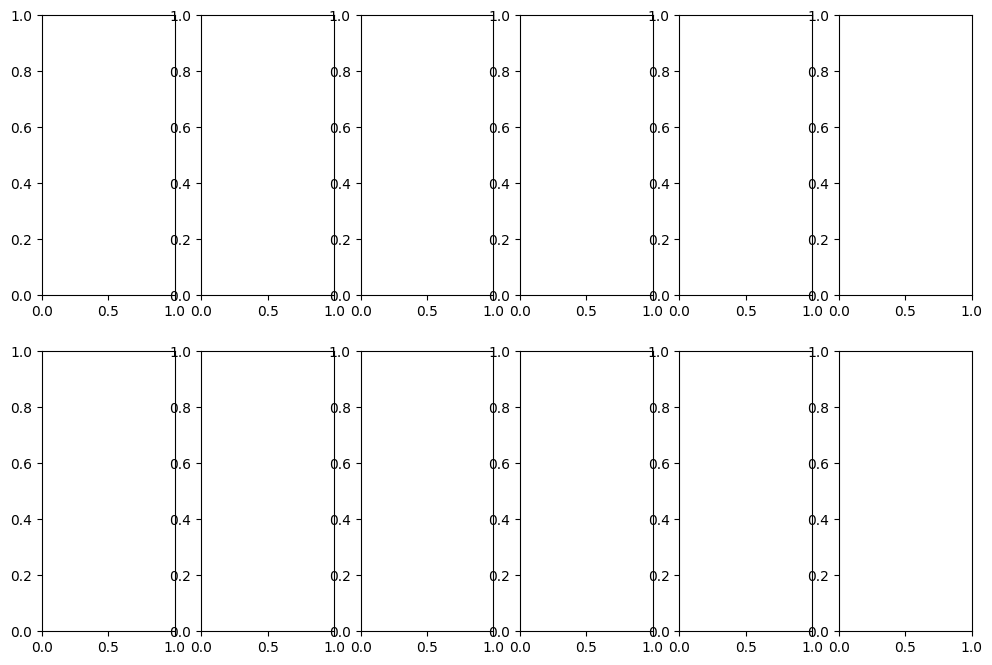

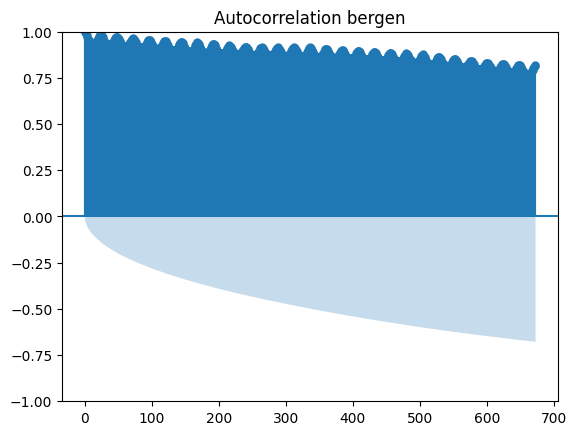

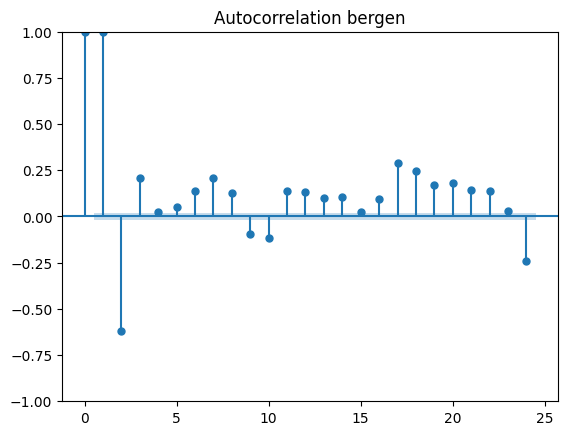

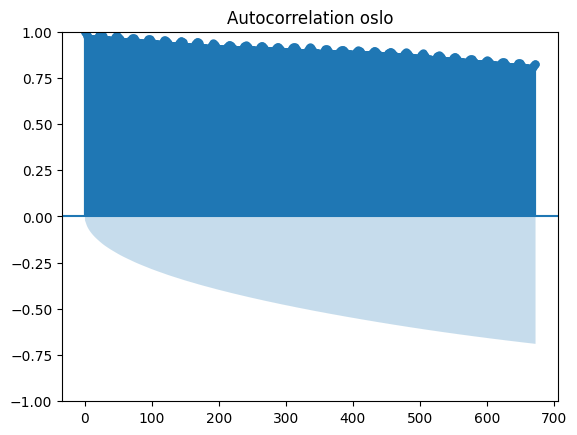

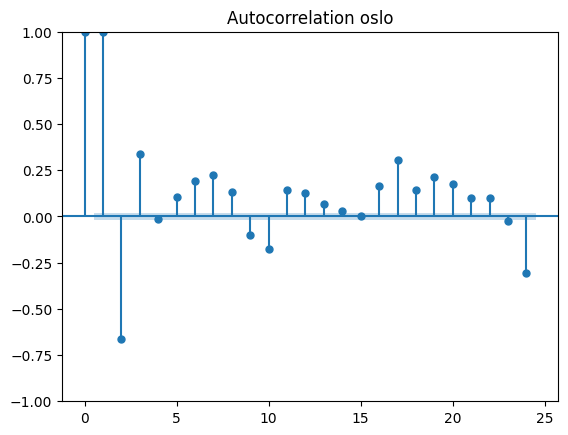

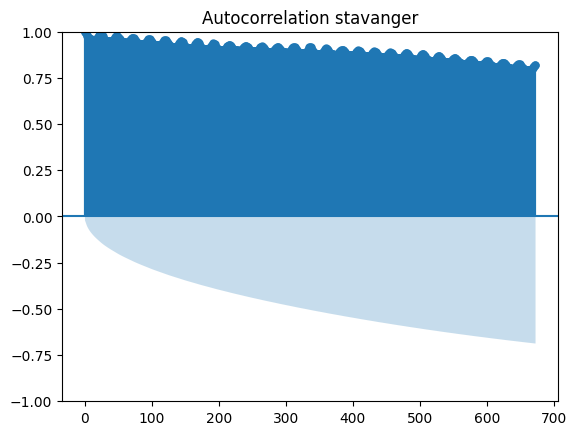

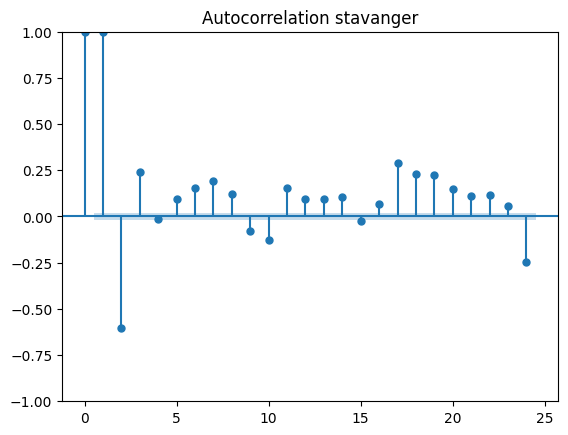

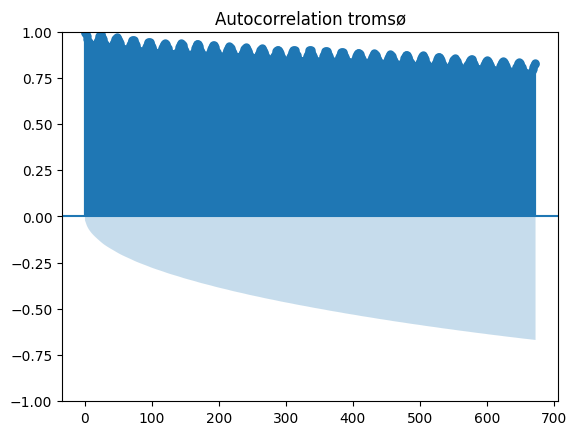

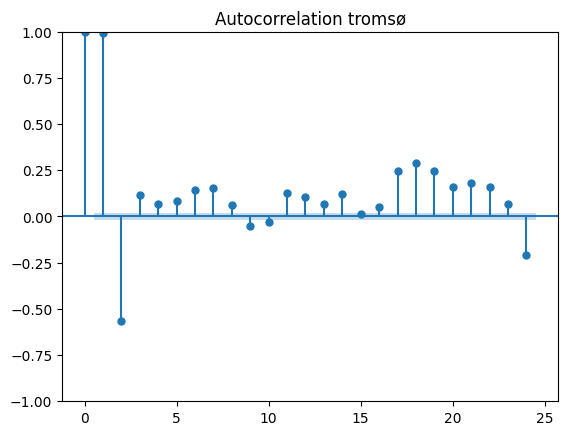

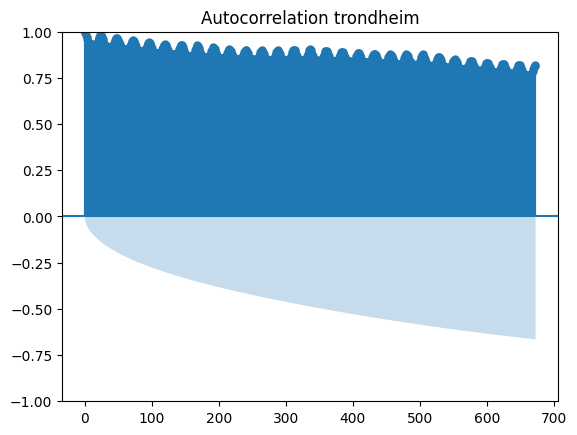

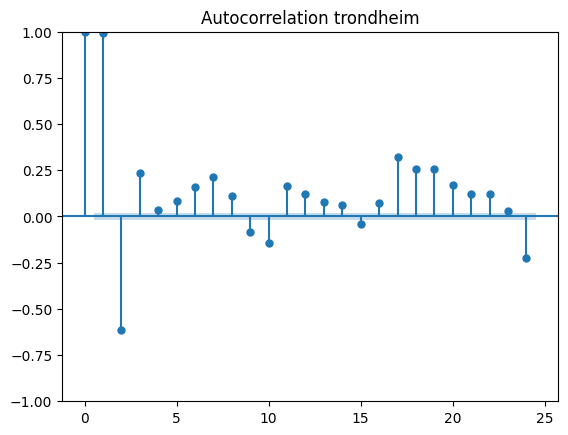

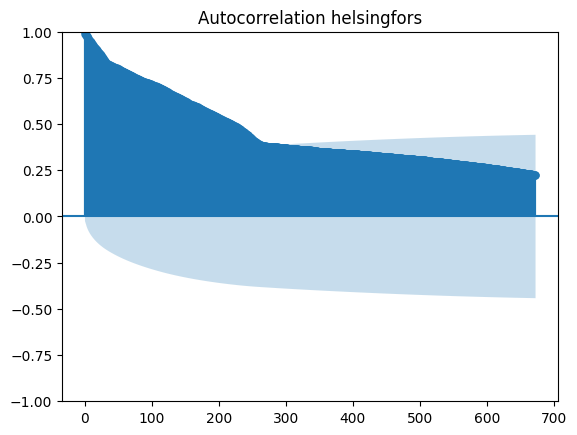

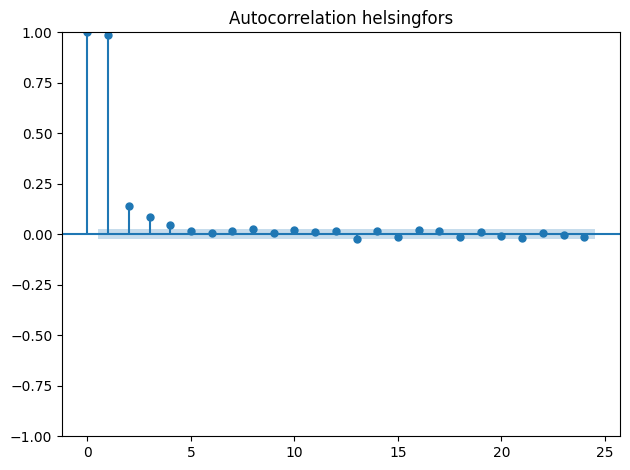

In [8]:
fig, axs = plt.subplots(2, 6, figsize=(12, 8))
for location in df.location.unique():
    plot_acf(df[df.location == location].set_index('time').consumption, lags=24*28, title='Autocorrelation ' + location)
    plot_pacf(df[df.location == location].set_index('time').consumption, lags=24, title='Autocorrelation ' + location)
    # df[df.location == location].set_index('time').consumption.plot(label=location, title='Consumption', figsize=(15,5))
plt.tight_layout()
plt.show()


#### Seasonal decompose

KeyError: 'timestamp'

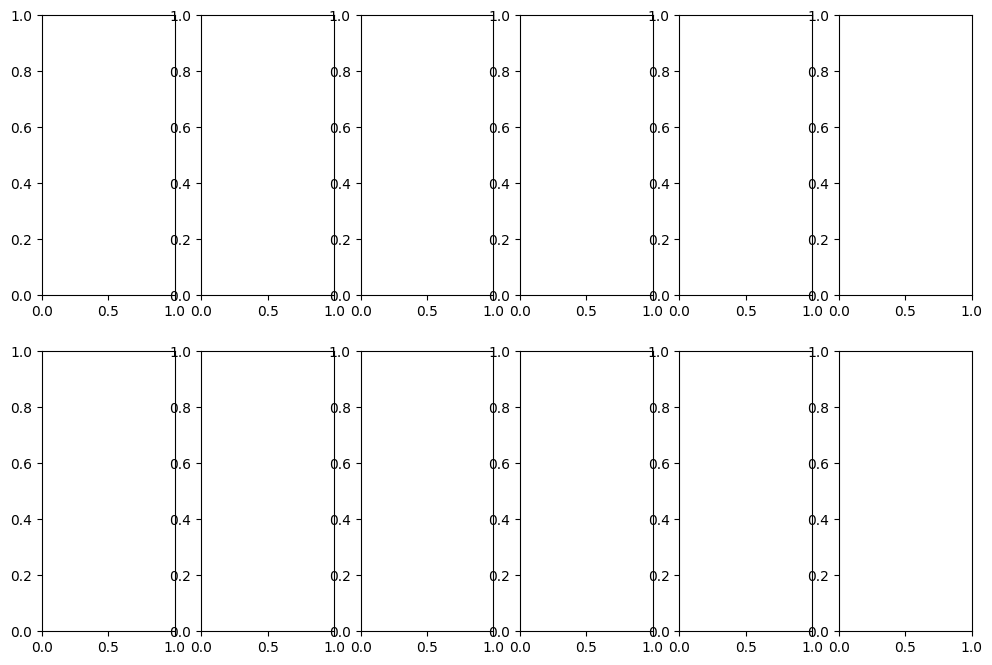

In [9]:
fig, axs = plt.subplots(2, 6, figsize=(12, 8))

for i in range(2):
    for j in range(3):
        location = df.location.unique().tolist()[(i-1)*3+j]
        axs[i, j].scatter(df['timestamp'], df['value'], s=10, marker='o', color='blue')
        axs[i, j].set_title(f'Subplot {i+1}-{j+1}')
        axs[i, j].set_xlabel('Timestamp')
        axs[i, j].set_ylabel('Value')

for location in df.location.unique():
    print(location)
    temp_df = df[df.location == location].set_index('time')[['consumption']]
    result = seasonal_decompose(temp_df, period=24, model='additive', extrapolate_trend='freq', two_sided=False)
    # result.plot()
    # result.seasonal[result.seasonal.index < result.seasonal.index.min() + timedelta(hours=24)].plot()
    result.seasonal.groupby(result.seasonal.index.hour).mean().plot(title=location)
    plt.show()

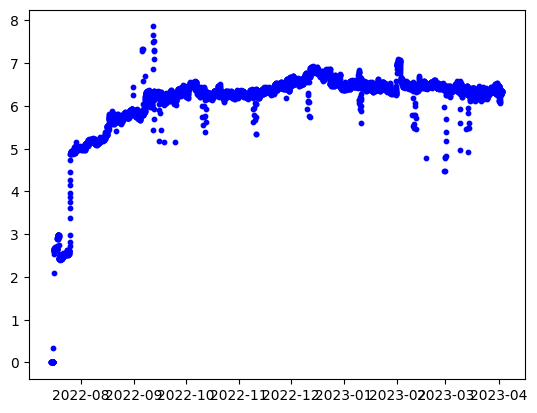

In [ ]:
plt.scatter(df[df.location=='helsingfors']['time'], df[df.location=='helsingfors']['consumption'], s=10, marker='o', color='blue')

In [ ]:
result.seasonal.index.min() + timedelta(hours=24)

Timestamp('2022-07-15 21:00:00')